<h1> Draft Master Thesis </h1>
Made by Jakob Lindstrøm and Marcus Hjertaas
<br>
<br>
This notebook shows how far we have come with our current work towards the master thesis, in regards of code. We are so to speak finished with data retrieval, Markowitz-algorithm and OGA-model. 
<br>
<br>
Exploratory data analysis, reinforcement learning algorithm and a comprehensive result (tables and plot) still remains. 

<h2> Current Content </h2>
We have retrieved data from a stock pool. We have traded thoose stocks with an Markowitz algorithm. We have performed the OGA model to look for allocation and selection effects. Where the benchmark is MPT and our experimental portfolio is a naive portfolio with equal weights (becuase RL is not finished). Lastly we show some plot to visualize how our result section might look like. 

<h2> Full access </h2>
To get full access to all code and modules; contact Jakob Lindstrøm. 

<h2> 1. Import libraries </h2>

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

import yfinance as yf

from scipy.optimize import Bounds
from scipy.optimize import LinearConstraint
from scipy.optimize import minimize

from Data_Retriever import DataRetriever as DatRet
from Markowitz_PT import MarkowitzPT as MPT
from Menchero_OGA import MencheroOGA as MOGA

<h2> 2. Define experimental variables </h2>

In [41]:
# Define number of trades
trading_n = 200

# Define number of days used to calcualte MPT
history_usage = 20

num_sectors = 5
num_stocks_peer_sector = 4

In [3]:
# Defining stock pool
ticker_df =  pd.DataFrame()
ticker_df["Petroleum"] = ["EQNR.OL", "AKRBP.OL", "SUBC.OL", "BWO.OL",]
ticker_df["Seafood (food)"] = ["ORK.OL", "MOWI.OL", "SALM.OL", "LSG.OL"]
# ticker_df["Materials"] = ["NHY.OL", "YAR.OL", "RECSI.OL", "BRG.OL"]
ticker_df["Technologies"] = ["TEL.OL", "NOD.OL", "ATEA.OL", "BOUV.OL"]
ticker_df["Financial"] = ["STB.OL", "DNB.OL", "GJF.OL", "AKER.OL"]
ticker_df["Shipping"] = ["WAWI.OL", "SNI.OL", "BELCO.OL", "ODF.OL"]
ticker_df

,Petroleum,Seafood (food),Technologies,Financial,Shipping
0,EQNR.OL,ORK.OL,TEL.OL,STB.OL,WAWI.OL
1,AKRBP.OL,MOWI.OL,NOD.OL,DNB.OL,SNI.OL
2,SUBC.OL,SALM.OL,ATEA.OL,GJF.OL,BELCO.OL
3,BWO.OL,LSG.OL,BOUV.OL,AKER.OL,ODF.OL


In [4]:
esg_scores = [36.6, 35.3, 17.9, 18, 
              18, 21.2, 18.7, 29.2, 
            #   15.7, 25.6, 25.6, 18.4, 
              19.8, 13.8, 18.1, 19, 
              17.2, 14, 17.2, 19.5, 
              19.7, 21.2, 26.8, 19.3]

<h2> 3. Retrieve data </h2>

In [5]:
# Retrieve data from yf API: y-m-d
data = DatRet(ticker_df, "2013-01-01", "2024-01-01")

# In function below, set log=True to check for data availability
data.retrieve_data()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

'--Data retrieved successfully--'

<h2> 4. Frequency trading using MPT </h2>

In [42]:
# Generate benchmark weights thorugh MPT using Sharpe ratio
benchmark = MPT(data.returns, history_usage, trading_n)
# IMPORTANT: In order to see  the effect of the weights, algo exclude last observation from optimization
benchmark.frequency_optimizing()

--Frequency trading using MPT successfully performed--


<h2> 5. Conduct performance analysis </h2>

In [43]:
# Naive experimental portfolio
ew = [np.repeat(1/20, 20) for i in range(trading_n)]
# Analysis 
analysis = MOGA(data.returns, benchmark.frequency_weights[-trading_n:], ew)
# Frequency analysis
analysis.frequency_analyser()

--Frequency analysis performed succesfully--


In [44]:
# data.returns

<h2> X. Ad-hoc result analysis </h2> 

<h3> X.1 Weights and returns </h3>

In [45]:
# part1 =  [pd.Series(stock) for sector in data.returns for stock in sector]
# part2 = pd.DataFrame(part1)
# part3 = part2.T

In [46]:
#Manual fixing weights
bw = [benchmark.frequency_weights[-trading_n + i][0] for i in range(trading_n)]

# Manual fixing returns
return_array =  [pd.Series(stock) for sector in data.returns for stock in sector]
return_df = pd.DataFrame(return_array)
return_tdf = return_df.T
ret = return_tdf[-trading_n:]+1

<h3> X.2 Calculating returns and active return </h3>

In [47]:
# Replicate historic geometric returns
bg = np.cumprod([bw[i]@ret.iloc[i] for i in range(trading_n)])
eg = np.cumprod([ew[i]@ret.iloc[i] for i in range(trading_n)])

# Active return
active_return = np.cumprod(analysis.allocation_effects*analysis.selection_effects)

<h3> X.3 Calculations on allocation and selection effects </h3>

In [48]:
# Recollect effects from sector level to portfolio level
port_all = analysis.allocation_effects.reshape(-1,num_sectors)
port_all_prod = [np.prod(port_all[i]+1) for i in range(len(port_all))]

port_sel = analysis.selection_effects.reshape(-1,num_sectors)
port_sel_prod = [np.prod(port_sel[i]+1) for i in range(len(port_sel))]

# Cumulative product of  active return, calcualted by effects
# active_return = np.cumprod([port_sel_prod[i]*port_all_prod[i] for i in range(trading_n)])
active_return = np.cumprod([port_sel_prod[i]*port_all_prod[i] for i in range(trading_n)])

In [49]:
active_return

array([1.00076804, 0.98781074, 0.98659497, 0.9945862 , 0.99100285,
       0.9977353 , 0.99859791, 0.98683541, 0.9876769 , 0.98748153,
       0.98560068, 0.98436693, 0.9835373 , 0.9732456 , 0.96587714,
       0.97386222, 0.9722086 , 0.97592485, 0.97623466, 0.97252389,
       0.97451283, 0.97479384, 0.97160251, 0.97503222, 0.97160864,
       0.96995504, 0.97014383, 0.96676462, 0.96696058, 0.96698625,
       0.96702564, 0.96682421, 0.96704852, 0.96787567, 0.97064074,
       0.9765893 , 0.9774286 , 0.97379564, 0.97532121, 0.97762164,
       0.97731205, 0.97301027, 0.97194095, 0.97710787, 0.97576096,
       0.9742829 , 0.97493002, 0.97597855, 0.97562509, 0.96959043,
       0.97007918, 0.97480229, 0.97325076, 0.97061775, 0.96583608,
       0.96768039, 0.96696423, 0.96906637, 0.97046091, 0.97076924,
       0.96940473, 0.96920582, 0.9711954 , 0.96506302, 0.96649001,
       0.96196869, 0.95973842, 0.97286899, 0.97733141, 0.98532367,
       0.9862448 , 0.97999913, 0.98040514, 0.9795013 , 0.97900

<h3> X.4 ESG score calculations  </h3>

In [50]:
average_esg = [bw[i]@esg_scores for i in range(trading_n)]

<h1> Plot and Results </h1>
<h3> Quality Control Plot </h3>

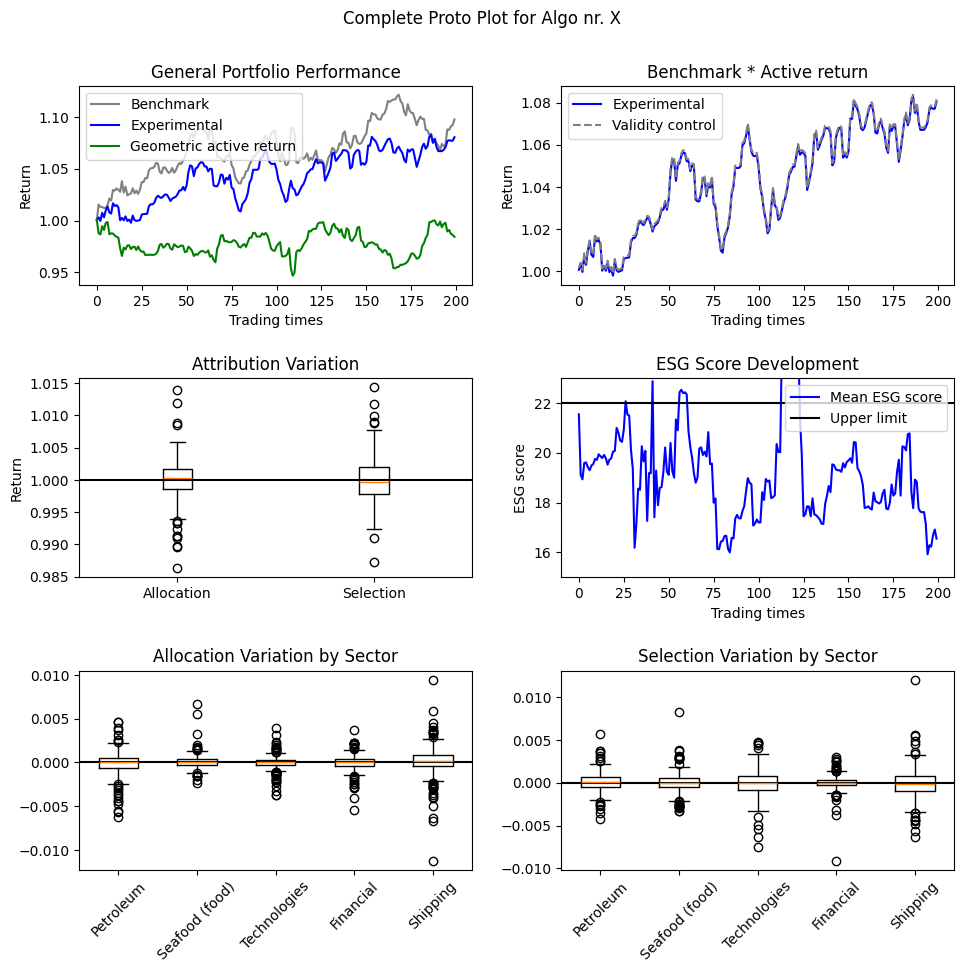

In [51]:
bigfig, ax = plt.subplots(3,2,figsize=(10,10))
ax[0,0].plot(bg, color="grey", label="Benchmark")
ax[0,0].plot(eg, color="blue", label="Experimental")
ax[0,0].plot(active_return, color="green", label= "Geometric active return")
ax[0,0].set_ylabel("Return")
ax[0,0].set_xlabel("Trading times")
ax[0,0].set_title('General Portfolio Performance')
ax[0,0].legend()

ax[0,1].plot(eg, color="blue", label="Experimental")
ax[0,1].plot((bg*active_return)+(0.001*(bg*active_return)), color="grey", linestyle="--", label="Validity control")
ax[0,1].set_ylabel("Return")
ax[0,1].set_xlabel("Trading times")
ax[0,1].set_title('Benchmark * Active return')
ax[0,1].legend()

data_arrays = [port_all_prod, port_sel_prod]
data_labels = ["Allocation", "Selection"]
ax[1,0].boxplot(data_arrays, tick_labels=data_labels)
ax[1,0].axhline(y=1, color="black")
ax[1,0].set_ylabel("Return")
ax[1,0].set_title('Attribution Variation')

ax[1,1].plot(average_esg, color="blue", label="Mean ESG score")
ax[1,1].axhline(y=22, color='black', linestyle='-', label="Upper limit")  
ax[1,1].set_ylim(15,23)
ax[1,1].set_ylabel("ESG score")
ax[1,1].set_xlabel("Trading times")
ax[1, 1].set_title('ESG Score Development')
ax[1,1].legend()

ax[2,0].boxplot(port_all)
ax[2,0].axhline(y=0, color="black")
ax[2,0].set_xticklabels(ticker_df.columns, rotation=45) 
ax[2,0].set_title('Allocation Variation by Sector')

ax[2,1].boxplot(port_sel)
ax[2,1].axhline(y=0, color="black")
ax[2,1].set_xticklabels(ticker_df.columns, rotation=45) 
ax[2,1].set_title('Selection Variation by Sector')

plt.suptitle('Complete Proto Plot for Algo nr. X', fontsize=12)
bigfig.tight_layout(pad=2.0)
plt.show()
# plt.close()


The first plot shows the experimental, benchmark and geometric active return. 
<br>
<br>
The second plot shows the benchmark and the product of experimental multiplied with geometric active return. It is clear that it foloows the same pattern, but there are some small errors. However, I use this plot to validate that our methods actually delievers the correct results. 
<br><br>
The next boxplot shows the distribution of allocation and selection effects on portfolio level for all trading times. The mean is about zero for both, but the variation is more positive for slection, than allocation. 
<br><br>
INTERESTING! Here one can observe a big  dradown in the mean ESG score. This do proabbly indicate that there have been signifcant changes in selection of weights. If we see similar things in other algorithms, are there any patterns?
<br><br>
For the two bottom plots, one can see allocation and selection variation broken down to sector level. Are there any similarities with these variation and thoose we found in the exploratory data analysis?

In [52]:
print("""
Missing a 2d scatterplot
 - x axis: variation allocation effect
 - y axis: variation selection effect
 - z axis: data point size dependent on active return
"""
)


Missing a 2d scatterplot
 - x axis: variation allocation effect
 - y axis: variation selection effect
 - z axis: data point size dependent on active return



In [53]:
trading_n

200

In [54]:
def frequency_analyser(returns, wb):
    """
    One liner
    
    Args
    
    Returns
    """
    return_array =  [pd.Series(stock) for sector in returns for stock in sector]
    return_df = pd.DataFrame(return_array)
    return_tdf = return_df.T

    # relevant_return_list = [return_tdf.iloc[-+i] for i in range(self.n_optimizations)]
    relevant_return_list = [return_tdf.iloc[-i] for i in range(trading_n, 0, -1)]
    # relevant_benW_list = self.benchmark_w


    # MOCK DATA SO FAR!!!
    total_n_stocks = 4 * 5
    relevant_expW_list = [[np.repeat(1/total_n_stocks, total_n_stocks)] for i in range(trading_n)]


    bench = []
    exper = []
    retlist = []
    for time in range(trading_n):
        bench.append( wb[time][0])
        exper.append(relevant_expW_list[time][0])
        retlist.append(relevant_return_list[time])
    return [retlist, bench, exper]

In [55]:
svar = frequency_analyser(data.returns, benchmark.frequency_weights)

In [56]:
# svar[0]

In [57]:
# svar[0][time]

In [58]:
svar[0][0][5]

np.float64(-0.0030537898451322627)

In [59]:
myret = svar[0][time]
myret

NameError: name 'time' is not defined

In [ ]:
time = 4
myfunc(4, 5, svar[0][time], svar[1][time], svar[2][time])

[ 4.85834917e-03  7.79597105e-05 -1.07784227e-03  1.15182656e-03
  5.96152787e-03]


[array([-2.94648931e-05,  1.95085382e-04, -4.97569086e-04, -6.13907863e-05,
         5.64652329e-04]),
 array([ 7.98013842e-04,  1.13134921e-04,  2.71837868e-05, -1.37770308e-04,
         2.09931876e-04])]

In [ ]:
def myfunc(n_stocks, n_sectors, ret, wb, we):
# Returns and weights on sector level for  benchmark
    w_b = np.array([sum(wb[int(i*n_stocks):int((i+1)*n_stocks)]) for i in range(n_sectors)])
    r_b = np.array([wb[int(i*n_stocks):int((i+1)*n_stocks)] @ ret[int(i*n_stocks):int((i+1)*n_stocks)] for i in range(n_sectors)])/w_b

    # Returns and weights on sector level for portfolio
    w_e = np.array([sum(we[int(i*n_stocks):int((i+1)*n_stocks)]) for i in range(n_sectors)])
    r_e = np.array([we[int(i*n_stocks):int((i+1)*n_stocks)] @ ret[int(i*n_stocks):int((i+1)*n_stocks)] for i in range(n_sectors)])/w_e

    # Total portfolio and benchmark return
    Re = np.dot(w_e, r_e)
    Rb = np.dot(w_b, r_b)
    print(r_e)

    # Naked allocation and selection effects
    sel_nkd = ((1+w_e*r_e) / (1+ w_e*r_b)) -1
    all_nkd = ((1 + (w_e-w_b)*r_b) /  (1+(w_e-w_b)*Rb)) -1

    q_top =  np.log(1+Re) - np.log(1+Rb) - sum(np.log((1+sel_nkd)*(1+all_nkd)))
    q_bottom = sum(np.log(1+sel_nkd)**2) + sum(np.log(1+all_nkd)**2)
    q_tot =  q_top/q_bottom

    # Perturbation terms
    gam_sel  = q_tot * np.log(1+sel_nkd)**2
    gam_all = q_tot * np.log(1+all_nkd)**2


    # Optimized selection and allocation effects
    sel_opt = (1+sel_nkd) * np.e**(gam_sel) - 1
    all_opt = (1+all_nkd) * np.e**(gam_all) - 1
    return [sel_opt, all_opt]
